In [2]:
import os
import cv2
import time
import json
import random
import pandas as pd
import numpy as np
import skimage.feature as skif
import mediapipe as mp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

2024-06-04 18:37:27.107272: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 18:37:27.161480: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 18:37:28.116158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
def makedir(directory): # Función para cargar los datos
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory


def save_plot(path, save_path=None, extra_img_path=None): # Función para guardar una imagen con cada clase
    classes = sorted(os.listdir(path))
    fig, axs = plt.subplots(5, 4, figsize=(20, 20))
    plt.rcParams.update({'font.size': 22})
    for i, c in enumerate(classes):
        img = mpimg.imread(path + c + '/' + os.listdir(path + c)[0])
        axs[i//4, i%4].imshow(img)
        axs[i//4, i%4].set_title(c)
        axs[i//4, i%4].axis('off')
    axs[4, 3].imshow(mpimg.imread(extra_img_path))
    axs[4, 3].axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

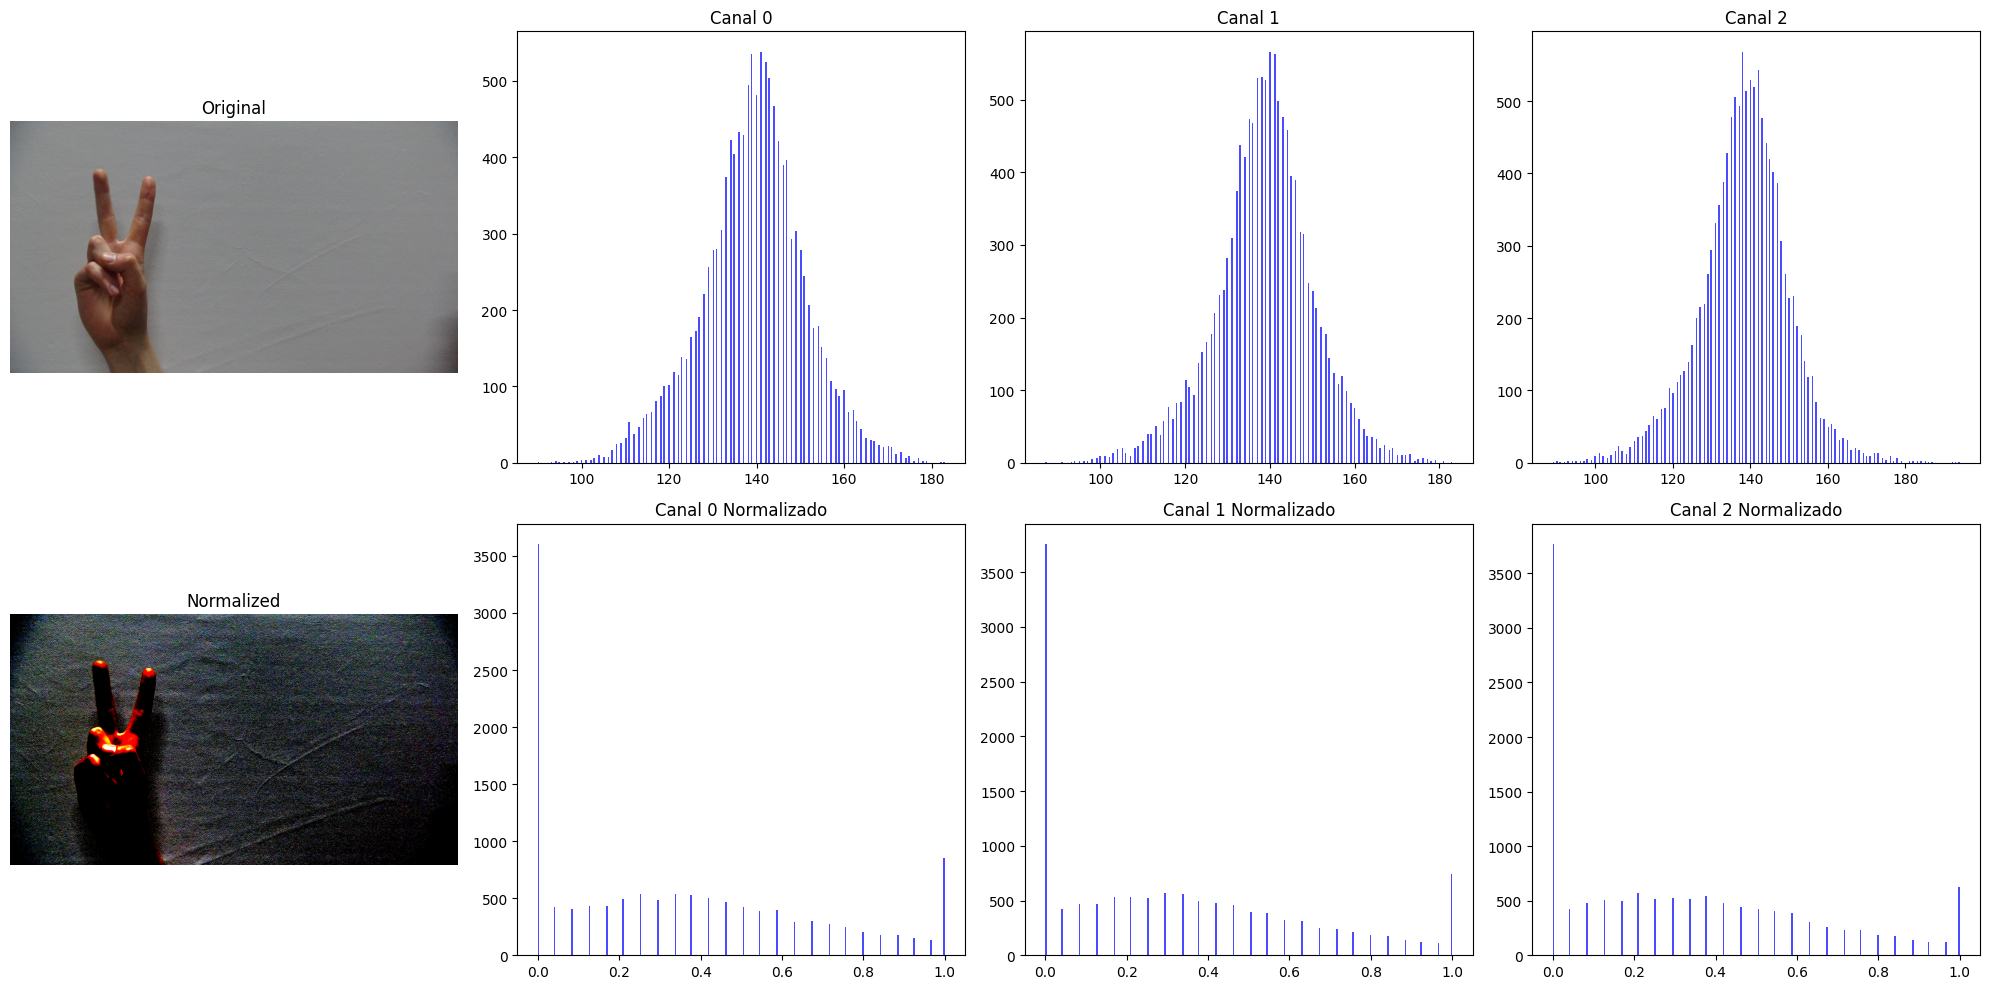

In [ ]:
# Ruta de la carpeta donde se encuentran las imágenes de las clases
classes_path = f'data/kaggle/classes'

# Definición de función para graficar histograma
def plot_histogram(ax, channel, title):
    ax.hist(channel.ravel(), bins=256, color='blue', alpha=0.7)
    ax.set_title(title)

# img = cv2.imread("./classes/E/DSC02287.JPG") # Cargar la imagen
img = random.choice(os.listdir(f'{classes_path}E'))  # Elige aleatoriamente el nombre de una imagen en la carpeta correspondiente a la clase
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Convertir de RGB a BGR

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # Crear una figura y un conjunto de ejes

axes[0, 0].imshow(img) 
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

# Graficar histogramas para cada canal de color
for i in range(3):
    channel = img[i]
    plot_histogram(axes[0, i + 1], channel, f'Canal {i}')

img_normalized = np.zeros_like(img, dtype=np.float32) # Crear una matriz para almacenar la imagen normalizada

channel = img / 255  # Normanizar la imagen dividiendo cada píxel por 255
channel_med = np.median(channel)  # Calcular la mediana
channel_std = np.std(channel)  # Calcular la desviación estándar

if channel_std > 0:
    img_normalized= (channel - channel_med) / channel_std # Normalizar la imagen utilizando la fórmula (x - media) / desviación estándar
else:
    img_normalized = 0 # Si la desviación estándar es cero, establecer todos los valores en cero

img_normalized = np.clip(img_normalized, 0, 1) # Asegurarse de que los valores estén en el rango [0, 1]

axes[1, 0].imshow(img_normalized)
axes[1, 0].set_title('Normalized')
axes[1, 0].axis('off')

# Graficar histogramas para cada canal de color normalizado
for i in range(3):
    channel_normalized = img_normalized[i]
    plot_histogram(axes[1, i + 1], channel_normalized, f'Canal {i} Normalizado')

plt.tight_layout()
plt.show()


In [4]:
def draw_hand_landmarks(frame, landmarks, margin=15): # Función para dibujar los puntos de referencia de la mano
    height, width, _ = frame.shape  # Obtiene las dimensiones del frame
    x_min, y_min, x_max, y_max = width, height, 0, 0  # Inicializa los límites del rectángulo que rodea la mano

    for i, point in enumerate(landmarks.landmark):
        x, y = int(point.x * width), int(point.y * height)  # Calcula las coordenadas del punto en píxeles
        color = (0, 255, 0) if i % 4 == 0 else (0, 0, 255)  # Alterna el color entre verde y rojo para cada punto
        cv2.circle(frame, (x, y), int(height * 0.01), color, -1)  # Dibuja un círculo en el punto

        # Actualiza las coordenadas mínimas y máximas para dibujar un rectángulo alrededor de la mano
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x)
        y_max = max(y_max, y)

    # Definir conexiones solo para el contorno de la mano y los dedos
    connections = [[1, 2], [2, 3], [3, 4],  # Dedo pulgar
                   [5, 6], [6, 7], [7, 8],  # Dedo índice
                   [9, 10], [10, 11], [11, 12],  # Dedo medio
                   [13, 14], [14, 15], [15, 16],  # Dedo anular
                   [17, 18], [18, 19], [19, 20],  # Dedo meñique
                   [0, 1],[0, 17],[1, 5], [5, 9], [9, 13], [13, 17]]  # Conexiones de la palma de la mano

    # Dibujar las conexiones entre los puntos de referencia de la mano
    for connection in connections:
        cv2.line(frame, (int(landmarks.landmark[connection[0]].x * width), int(landmarks.landmark[connection[0]].y * height)),
                         (int(landmarks.landmark[connection[1]].x * width), int(landmarks.landmark[connection[1]].y * height)), (0, 0, 255), 2)

    hand_width = x_max - x_min
    hand_height = y_max - y_min

    # Calcula el tamaño del cuadrado que rodea la mano
    square_side = max(hand_width, hand_height)

    # Calcula las coordenadas del cuadrado que rodea la mano
    x_min_square = x_min + hand_width // 2 - square_side // 2
    x_max_square = x_min_square + square_side
    y_min_square = y_min + hand_height // 2 - square_side // 2
    y_max_square = y_min_square + square_side

    # Añadir un margen al cuadrado
    x_min_square = max(0, x_min_square)
    y_min_square = max(0, y_min_square)
    x_max_square = min(width, x_max_square)
    y_max_square = min(height, y_max_square)

    # Dibujar el cuadrado que rodea la mano
    cv2.rectangle(frame, (x_min_square-margin, y_min_square-margin), (x_max_square+margin, y_max_square+margin), (0, 0, 255), 2)

    # Return the square bounding box instead of the hand rectangle
    return frame, (x_min_square-margin, y_min_square-margin, x_max_square+margin, y_max_square+margin)




I0000 00:00:1717548007.039429   10968 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717548007.040159   32381 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.8-manjaro1.1), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)


data/kaggle/classes/U/DSC01962.JPG


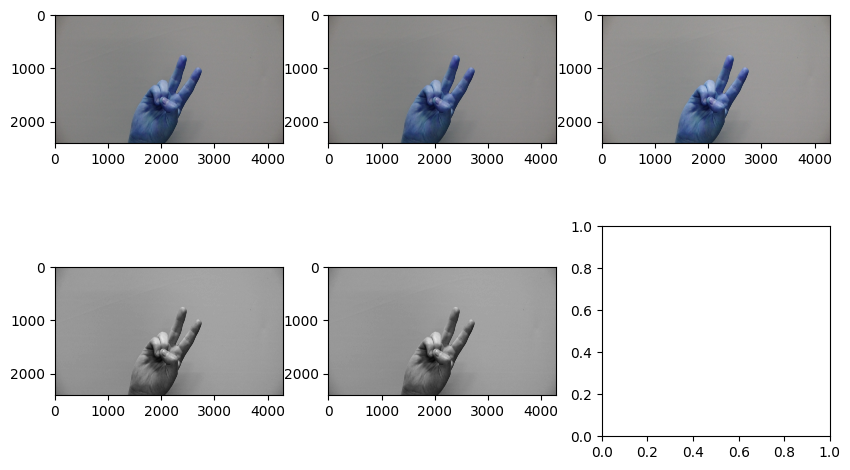

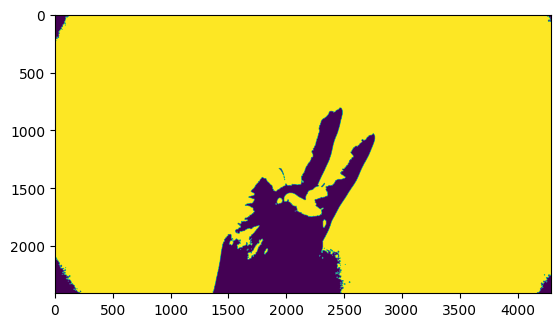

In [17]:
def preprocess_image(frame):
    # Noise reduction
    fig, axs = plt.subplots(2,3, figsize=(10, 6))
    axs[0, 0].imshow(frame)
    frame = cv2.GaussianBlur(frame, (5, 5), 0)
    axs[0, 1].imshow(frame)
    
    # Intensity normalization
    frame = cv2.normalize(frame, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    axs[0, 2].imshow(frame)
    # Color correction (convert to grayscale)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    axs[1, 0].imshow(frame, cmap='gray')

    # Convert the image to uint8
    frame = cv2.convertScaleAbs(frame, alpha=(255.0))
    axs[1, 1].imshow(frame, cmap='gray')

    plt.show()
    
    return frame

def segment_hand(frame):
    # Thresholding
    _, frame = cv2.threshold(frame, 127, 255, cv2.THRESH_BINARY)
    
    # Morphological operations
    kernel = np.ones((5,5),np.uint8)
    frame = cv2.morphologyEx(frame, cv2.MORPH_OPEN, kernel)
    frame = cv2.morphologyEx(frame, cv2.MORPH_CLOSE, kernel)
    
    return frame

def extract_features(frame):
    # Local descriptors (HOG)
    hog = skif.hog(frame, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys')
    
    # Texture features (GLCM)
    glcm = skif.greycomatrix(frame, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], normed=True, symmetric=True)
    contrast = skif.greycoprops(glcm, 'contrast')
    dissimilarity = skif.greycoprops(glcm, 'dissimilarity')
    homogeneity = skif.greycoprops(glcm, 'homogeneity')
    energy = skif.greycoprops(glcm, 'energy')
    correlation = skif.greycoprops(glcm, 'correlation')
    
    # Combine features into a single array
    features = np.hstack([hog, contrast.flatten(), dissimilarity.flatten(), homogeneity.flatten(), energy.flatten(), correlation.flatten()])
    
    return features

def process_images(directory):
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()

    for subdir, dirs, files in os.walk(directory):
        rand_dir = random.choice(dirs)
        rand_file = random.choice(os.listdir(f'{directory}/{rand_dir}'))

        filepath = f'{directory}/{rand_dir}/{rand_file}'

        if filepath.endswith(".JPG") or filepath.endswith(".jpg"):
            print(filepath)
            frame = cv2.imread(filepath)
            
            # Preprocessing
            frame = preprocess_image(frame)
            
            # Hand segmentation
            frame = segment_hand(frame)
            
            img = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
            hands_results = hands.process(img)
            plt.imshow(frame)

            if hands_results.multi_hand_landmarks:
                for landmarks in hands_results.multi_hand_landmarks:
                    drawn_frame, hand_rect = draw_hand_landmarks(frame, landmarks)
                    try: 
                        frame_resized = cv2.resize(drawn_frame[hand_rect[1]:hand_rect[3], hand_rect[0]:hand_rect[2]], (512, 512))
                        
                        # Feature extraction
                        features = extract_features(frame_resized)
                        print(features)
                        
                        plt.imshow(frame_resized) 
                        plt.show()  
                        # cv2.imwrite(os.path.join(new_subdir, file), frame_resized)


                    except Exception as e: 
                        print(f"Error processing file {filepath}: {e}")
        break
                
    hands.close()

process_images('data/kaggle/classes')

In [5]:
def capture_frames(hands, classes, path, num_frames=200):
    frame_step  = 20
    classes_idx = {c: i for i, c in enumerate(classes)}

    cap = cv2.VideoCapture(0)  # Inicializa la cámara

    # makedir(path)  # Crea la carpeta 'data' si no existe

    # for c in classes:
    #     makedir(path + c)
    letter_idx = 0  # Índice de la letra actual
    frames_taken = 0  # Contador para el número de frames tomados por letra
    frame_count = 0  # Contador para el número total de frames tomados

    frames_dataframe = []

    while True:
        ret, frame = cap.read()  # Lee un frame de la cámara
        frame_count += 1  # Incrementa el contador de frames

        # Si no se pudo leer el frame, termina el ciclo
        if not ret:
            print("Error al leer el frame")
            break

        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convierte el frame de BGR a RGB

        hands_results = hands.process(img)  # Procesa el frame con el modelo de manos

        # Dibuja puntos y líneas para las manos en la imagen negra
        if hands_results.multi_hand_landmarks and frame_count % frame_step == 0:
            for landmarks in hands_results.multi_hand_landmarks:
                drawn_frame, hand_rect = draw_hand_landmarks(frame, landmarks)  # Dibuja puntos y líneas para las mano
                
                if frames_taken < num_frames:
                    letter = classes[letter_idx]  # Obtiene la letra actual

                    # recortar la mano y guardarla 
                    try:
                        reshaped_frame = drawn_frame[hand_rect[1]:hand_rect[3], hand_rect[0]:hand_rect[2]] # Recorta el cuadrado que rodea la mano y lo redimensiona
                        reshaped_frame = cv2.cvtColor(reshaped_frame, cv2.COLOR_BGR2GRAY)  # Convierte la imagen a escala de grises
                        reshaped_frame = cv2.resize(reshaped_frame, (28, 28), interpolation=cv2.INTER_AREA) # Redimensiona la imagen a 28x28 píxel  es
                        
                        # guardar el frame en el dataframe
                        frames_dataframe.append([classes_idx[letter]] + reshaped_frame.flatten().tolist())

                        # reshaped_frame = reshaped_frame.reshape(1, 28, 28,  1)
                        frames_taken += 1  # Incrementa el contador de frames tomados


                    except Exception as e:
                        print(e)
                        pass
                            
                if frames_taken >= num_frames:
                    time.sleep(3)
                    letter_idx += 1
                    frames_taken = 0
                if letter_idx >= len(classes):
                    pd.DataFrame(frames_dataframe, columns=['label'] + ['pixel'+str(i) for i in range(len(frames_dataframe[0])-1)]).to_csv(f'{path}/frames{time.strftime("%Y%m%d%H%M%S")}.csv', index=False)
                    break
            
            cv2.putText(drawn_frame, letter + ' ' + str(frames_taken), (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.imshow('Pose Detection', frame)  # Muestra el frame con las manos detectadas
        
        # Si se presiona la tecla 'q', termina el ciclo
        if (cv2.waitKey(1) & 0xFF == ord('q')) or letter_idx >= len(classes):
            break

    cap.release()  # Libera la cámara
    cv2.destroyAllWindows() # Cerrar todas las ventanas
    hands.close() # Cerrar el modelo de manos


In [6]:
mp_hands = mp.solutions.hands # Importar el modelo de manos de MediaPipe
hands = mp_hands.Hands(max_num_hands=1) # Inicializar el modelo de manos

# Ruta de la carpeta donde se guardarán las imágenes en formato csv
path_db = f'data/backups/'
classes = list(json.load(open(f'{path_db}classes.json')).keys())
print(classes)
capture_frames(hands, classes, path_db, num_frames=5) # Capturar frames de la cámara y guardarlos en carpetas correspondientes a cada letra



I0000 00:00:1717544266.140837   10968 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1717544266.143981   11052 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.0.8-manjaro1.1), renderer: Mesa Intel(R) Xe Graphics (TGL GT2)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


['A', 'B', 'C', 'D', 'E', 'F', 'G', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U']


OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'

OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



![Imagen de Señas](data/esp_sign.png)